# Dimensionality reduction for audio organization
Author: Leonardo Pepino 

In this tutorial dimensionality reduction techniques for audio organization will be explored. You will need the following libraries to run this notebook:

- Numpy
- Librosa
- Sounddevice
- Scikit-learn
- Keras
- Tensorflow
- Matplotlib
- Umap

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sounddevice as sd
import librosa

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from keras.layers import Input,Dense,Conv2D,MaxPooling2D,UpSampling2D, Reshape, Flatten, Lambda
from keras.models import Model
from keras import backend as k

%matplotlib inline
#%matplotlib widget

We are going to need many audio files. In order to make the task easier, audio samples should be short. In this notebook, I will use the NSynth Dataset test set which provides 4096 samples of notes being played by different musical instruments. Samples are 4 seconds long. You can download the samples at: https://magenta.tensorflow.org/datasets/nsynth. Once you download them, place audio files in a folder called "samples" within the notebook directory.

Now that the dataset was downloaded, let's meet the data:
- Mono/Stereo?
- Sampling rate?
- All files same length?
- Listen to some samples -> Do we need to take into account temporal evolution? -> Stationary? -> Silences? -> Noise? -> Percussive or tonal? -> ...

If you don't want to wait a long time, do not run the cell below.

In [135]:
path = ".//samples"
filelist = os.listdir(path) #Get all audio files in a list
nchannels = np.zeros((len(filelist),))
lengths = np.zeros((len(filelist),))
srs = np.zeros((len(filelist),))
for i, file in enumerate(filelist): #Open each file and store the number of channels, length and sampling rates.
    [audio,fs] = librosa.load(path + '//' + file)
    tensorshape = np.shape(audio)
    if (len(tensorshape) == 1):
        nchannels[i] = 1
    else:
        nchannels[i] = tensorshape[1]
    lengths[i] = tensorshape[0]
    srs[i] = fs
nchannels = np.unique(nchannels)
lengths = np.unique(lengths)
srs = np.unique(srs)

print('Channel numbers in dataset:')
print(nchannels)
print('Sample lengths in dataset:')
print(lengths)
print('Sampling rates in dataset:')
print(srs)

Channel numbers in dataset:
[1.]
Sample lengths in dataset:
[88200.]
Sampling rates in dataset:
[22050.]


We can see that the dataset is pretty nice because all samples have the same duration, sampling rate and number of channels. If we listen to them we will notice that most of the audio samples spectrum does not change along time (they are stationary) and there are no silences. 
So, each audio sample is a vector of 88200 elements. The goal of this tutorial will be to "summarize" those 88200 elements in just 2 numbers, which will be represented as a 2D point. So, dimensionality reduction has to be performed (from 88200 to 2 dimensions) and the purpose is visualization, because it is hard to see in 88200 dimensions. We are limited to visualizing things in 3 dimensions or less (although we could use color as a fourth dimension, and time as a fifth if we animate the plots, but it would be hard to interpretate).

Some possible approaches to perform dimensionality reduction in audio are:

- Start from raw data -> could be directly the samples or maybe a spectrogram -> Most traditional methods can't deal with very high dimensionality -> Use deep learning -> Autoencoders -> Features are obtained -> could be 2 so that we do not need further dimensionality reduction, or a larger number, but we would need to reduce dimensionality again with another technique.
- Manually extract some features -> Mel frequency cepstral coefficients, Loudness, Roughness, Spectral Rolloff, ... -> These are hand-crafted features and will let us reduce a bit of dimensionality -> Then we can apply methods like PCA, tSNE, UMap,...   

In this notebook I used MFCC instead of raw data... raw data is for a next tutorial. Anyway, we will train an autoencoder ;)

So the first step is to get the MFCC. LibROSA library has a function that does it for us. I chose the frames to be 2048 samples long with an overlap factor of 50%.

In [20]:
def organisedataset(filelist):
    featurevector = []
    filevector=[]
    nfft = 2048 #How many samples for each analysis window
    hop_size = 1024 #This gives us 50% of overlap
    
    for audiofile in filelist:
        [audio,fs] = librosa.load(path + "\\" + audiofile)
        mfcc = librosa.feature.mfcc(y=audio,sr=fs,n_fft = nfft,hop_length = hop_size,n_mfcc=32) #We will get 32 MFCCs for each analysis window  
        featurevector.append(mfcc)
        filevector.append(audiofile) #Also store the filenames for later.
    
    return [featurevector,filevector]

path = ".//samples"
filelist = os.listdir(path)
[xvector,metavector] = organisedataset(filelist)

We obtained a list with 2 elements. The first is a numpy tensor with the features for all audio samples. The second is a list of the filenames which we will need for the interactive exploration.

If running the cell above took a long time, it will be a good idea to save the results to a file:

In [22]:
np.save('nsynthmfcc.npy',[xvector,metavector])

Let's take a quick look at the tensor with features:

In [26]:
print('The shape of our tensor is:')
print(np.shape(xvector))
print('Minimum value: ' + str(np.min(xvector)))
print('Maximum value: ' + str(np.max(xvector)))
print('Mean value: ' + str(np.mean(xvector)))
print('Standard deviation: ' + str(np.std(xvector)))

The shape of our tensor is:
(4096, 32, 87)
Minimum value: -954.6725670966737
Maximum value: 336.847264015782
Mean value: -10.819791192414431
Standard deviation: 83.45644645399183


We can see the features take a large range, so a possible strategy is to turn the values into z-scores, so that the mean is 0 and the standard deviation 1.
But first, I don't like the number 87, so we will use just the first 32 frames, but... is it right? As I said at the beginning, samples in NSynth dataset do not change a lot over time, so I think that the first 32 frames will be representative of the 87 and will let us work in an easier way with autoencoders (no paddings and that stuff...), but remember: if You are using another dataset maybe you will need all the frames, or maybe just to take some global descriptors such as the mean, std, kurtosis, skewness... of each MFCC.

In [30]:
x = np.zeros((len(xvector),32,32))
for k, el in enumerate(xvector):
    x[k,:,:] = el[:,:32]
    
xnorm = (x - np.mean(x,axis=0))/np.std(x,axis=0)

print('The shape of our tensor is:')
print(np.shape(xnorm))
print('Minimum value: ' + str(np.min(xnorm)))
print('Maximum value: ' + str(np.max(xnorm)))
print('Mean value: ' + str(np.mean(xnorm)))
print('Standard deviation: ' + str(np.std(xnorm)))

The shape of our tensor is:
(4096, 32, 32)
Minimum value: -5.444073214861761
Maximum value: 7.6798043887103145
Mean value: 3.1712913545201005e-17
Standard deviation: 0.9999999999999998


Well that is a little better, but I don't like the range of data.

In [31]:
xnorm = xnorm/np.max(np.abs(xnorm))

print('The shape of our tensor is:')
print(np.shape(xnorm))
print('Minimum value: ' + str(np.min(xnorm)))
print('Maximum value: ' + str(np.max(xnorm)))
print('Mean value: ' + str(np.mean(xnorm)))
print('Standard deviation: ' + str(np.std(xnorm)))

The shape of our tensor is:
(4096, 32, 32)
Minimum value: -0.7088817552260592
Maximum value: 1.0
Mean value: 2.0599841277224584e-18
Standard deviation: 0.1302116498527031


Now our data is in a better range, although std was modified also, but let's see what happens

A magic function will be defined which will allow us to make a 2D scatter plot and when clicking over a point, the associated audio file will be played.

### Important: if you want to activate the interactive plot comment %matplotlib inline and uncomment %matplotlib widget in the first cell (where all imports are done) 

In [164]:
def onpick(event):
    ind = event.ind #Get the index of the clicked point
    if len(ind)>1: #If there were many points near the click point, choose the closest one
        point = event.artist
        datax = point.get_xdata()
        datay = point.get_ydata()
        datax,datay = [datax[i] for i in ind],[datay[i] for i in ind]
        msx, msy = event.mouseevent.xdata, event.mouseevent.ydata
        dist = np.sqrt((np.array(datax)-msx)**2 + (np.array(datay)-msy)**2)
        ind = ind[np.argmin(dist)]
    else:
        ind = ind[0]
    [audio,fs] = librosa.load(path + "//" + metavector[ind]) #Load the audio file associated with the clicked point
    sd.play(audio,fs) #Play it
    
    
def interactiveplot(dimreduced,title):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_title(title)

    line = ax.plot(dimreduced[:,0],dimreduced[:,1],'o',markersize=2,picker = 5)  
    fig.canvas.mpl_connect('pick_event',onpick)

    plt.show()

First let's see what happens if we apply Principal Component Analysis (PCA) directly on the features.

In [137]:
xnorm1D = np.reshape(xnorm,(4096,1024)) #The first axis is for each sample and the second for each feature.
pcasolver = PCA(n_components = 2) #We could set n_components = 3 and visualize it in 3D. Try it!
dimreducedPCA = pcasolver.fit_transform(xnorm1D)

Well a thing to notice is that PCA is really fast even with 1024 dimensions! and you know, time is gold.

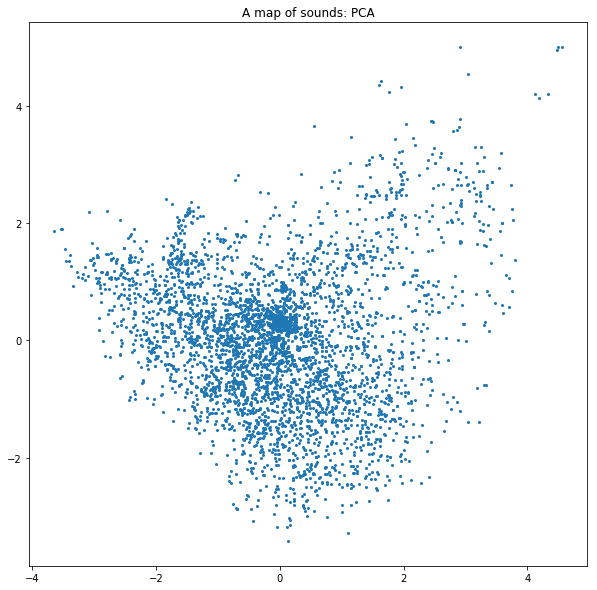

In [165]:
interactiveplot(dimreducedPCA,'A map of sounds: PCA')

In this map there are no clear clusters, but if you explore the sounds, similar sounds are close and that is good. So PCA in spite of being a linear technique and very fast, gave us decent results.

Before building the autoencoder, let's try using UMap which can also deal with large dimensionality. UMap is not included in sklearn, so we need to install UMap library.

In [142]:
import umap

umapsolver = umap.UMAP()
dimreducedUMAP = umapsolver.fit_transform(xnorm1D)

FigureCanvasNbAgg()

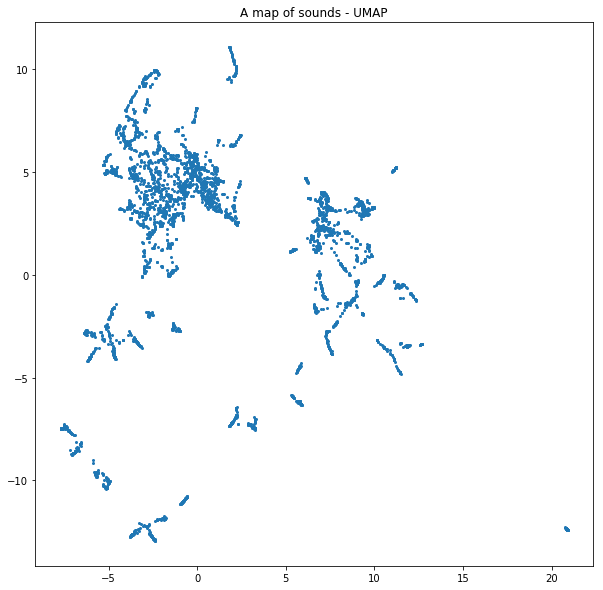

In [166]:
interactiveplot(dimreducedUMAP, 'A map of sounds - UMAP')

That was fast too! and results are a lot better. There are clear clusters which share similar features such as: pitch, temporal evolution (for example vibratos or glissandos), timbre, etc...

One thing to notice is that if you run the cell above multiple times, results will differ...

UMap is great!

But now it is the turn of the neural networks...

In [67]:
xnormNN = np.reshape(xnorm,(len(xvector),32,32,1)) #We give the array a shape to work with Keras

input_feature = Input(shape=(32,32,1)) #This is the input layer

encoder = Conv2D(16,(2,2),padding='same')(input_feature) #The encoder applies convolution layers followed by max-pooling layers multiple times
encoder = MaxPooling2D((2,2))(encoder)
encoder = Conv2D(16,(2,2),padding='same')(encoder)
encoder = MaxPooling2D((2,2))(encoder)
encoder = Conv2D(32,(2,2),padding='same')(encoder)
encoder = MaxPooling2D((2,2))(encoder)
encoder = Conv2D(64,(2,2),padding='same')(encoder)
encoder = MaxPooling2D((2,2))(encoder) #Here we have (2,2,64) tensors -> 256 elements
encoder = Flatten()(encoder) #We make the outputs flat so that they can be fed to a fully connected layer
encoded = Dense(32,activation = "relu")(encoder) #This is the latent space
decoder = Dense(256,activation = "relu")(encoded) #Here the decoder starts, it is symmetrical with respect to the encoder
decoder = Reshape((2,2,64))(decoder) 
decoder = UpSampling2D((2,2))(decoder)
decoder = Conv2D(32,(2,2),padding = 'same')(decoder)
decoder = UpSampling2D((2,2))(decoder)
decoder = Conv2D(16,(2,2),padding = 'same')(decoder)
decoder = UpSampling2D((2,2))(decoder)
decoder = Conv2D(16,(2,2),padding = 'same')(decoder)
decoder = UpSampling2D((2,2))(decoder)
decoder = Conv2D(1,(2,2),padding = 'same')(decoder)
autoencoder = Model(input_feature,decoder) #The input and output nodes of the model are specified

autoencoder.summary()
autoencoder.compile(optimizer = 'adam',loss = 'mse') #Adam usually gives me good results
autoencoder.fit(xnormNN,xnormNN,epochs = 50,batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        1040      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
__________

It took some time so we will save the trained model in a file

In [69]:
autoencoder.save('ae.h5')

Now, let's see if the autoencoder can reconstruct the inputs

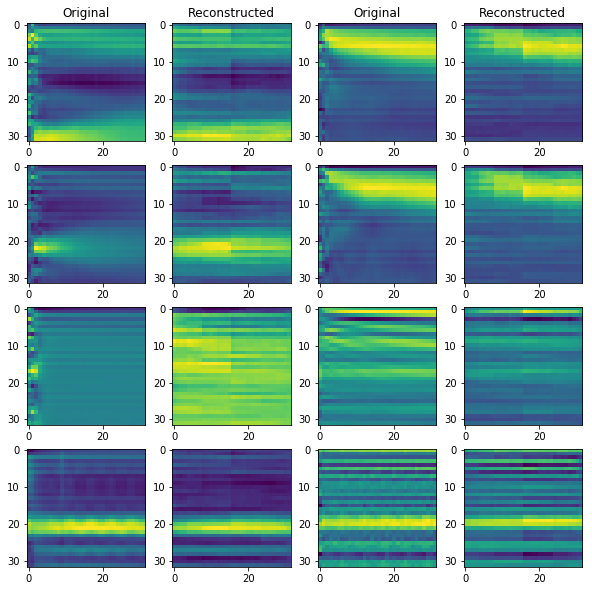

In [168]:
xpred = autoencoder.predict(xnormNN)
fig, axes = plt.subplots(4,4,figsize=(10,10))
axes[0,0].set_title('Original')
axes[0,1].set_title('Reconstructed')
axes[0,2].set_title('Original')
axes[0,3].set_title('Reconstructed')
for i, j in enumerate(np.random.randint(100,4092,size=(4,))):
    axes[i,0].imshow(xnormNN[j,:,:,0]) 
    axes[i,1].imshow(xpred[j,:,:,0])
    axes[i,2].imshow(xnormNN[j-100,:,:,0]) 
    axes[i,3].imshow(xpred[j-100,:,:,0])
    

Reconstructions are not so good as those you would see if using an autoencoder with MNIST, but anyway they reconstruct the overall "shape".

Now that our samples are represented in a lower dimensional space (32), the popular technique tSNE can be applied, but... what happens if we use an autoencoder with a latent space of 2 neurons for visualization. Let's try it!

First, let's get the latent space neurons output for all samples:

In [91]:
encoder1 = Model(input_feature,encoded) #This model has the latent space as output
latentspace1 = encoder1.predict(xnormNN)
print(np.shape(latentspace1))

(4096, 32)


Great!, now it is time to build a new small autoencoder which will take these 32 dimensional inputs and reconstruct them in its output from a 2 dimensional latent space. This autoencoder will be a variational one (VAE) and the code is based on keras tutorials. The idea is that the latent space neurons will output the mean and standard deviation of a normal distribution instead of values, and then we will sample from the resulting distribution and decode it. This generates a better-formed latent space. 

In [107]:
import keras.backend as k

def sampling(args):
    encodedmean, encodedlogsigma = args
    epsilon = k.random_normal(shape=(128,2),mean = 0, stddev=0.1)
    
    return encodedmean + k.exp(encodedlogsigma)*epsilon

input_latent = Input(shape=(32,))
encoder = Dense(16,activation = "relu")(input_latent)
encodedmean = Dense(2)(encoder)
encodedlogsigma = Dense(2)(encoder)
z = Lambda(sampling,output_shape=(2,))([encodedmean,encodedlogsigma])
decoder = Dense(16,activation = "relu")(z)
decoder = Dense(32,activation = "relu")(decoder)

def vaeloss(x,x_decoded):
    x_loss = k.sqrt(k.mean(k.square(x-x_decoded)))
    kl_loss = -0.5*k.mean(1+encodedlogsigma-k.square(encodedmean)-k.exp(encodedlogsigma),axis = -1)
    return x_loss + kl_loss
    
autoencoder2 = Model(input_latent,decoder)
autoencoder2.summary()
autoencoder2.compile(optimizer = 'adam',loss = vaeloss)
autoencoder2.fit(latentspace1,latentspace1,epochs = 50,batch_size=128)

encoder2 = Model(input_latent,encodedmean)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
dense_34 (Dense)                (None, 16)           528         input_10[0][0]                   
__________________________________________________________________________________________________
dense_35 (Dense)                (None, 2)            34          dense_34[0][0]                   
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 2)            34          dense_34[0][0]                   
__________________________________________________________________________________________________
lambda_4 (

In [144]:
dimreducedAE = encoder2.predict(latentspace1)

FigureCanvasNbAgg()

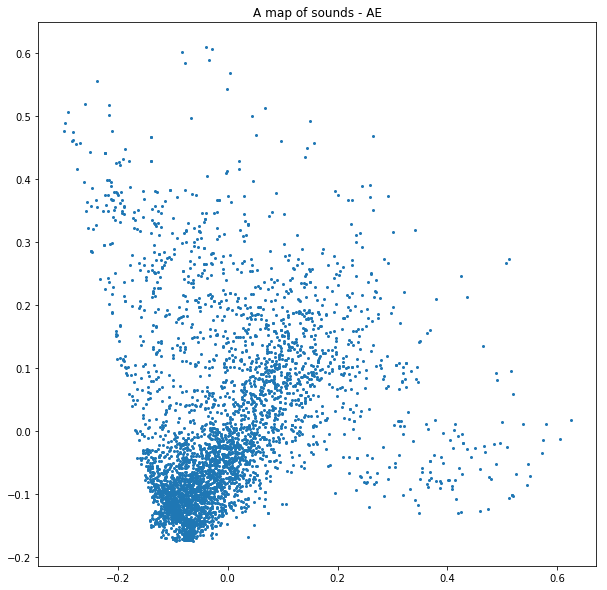

In [169]:
interactiveplot(dimreducedAE, 'A map of sounds - AE')

Well that is not so good. Let's keep the 32 dimensional embeddings and use PCA, tSNE and UMap and see what happens

In [145]:
pcasolver = PCA(n_components = 2)
dimreducedAEPCA = pcasolver.fit_transform(latentspace1)

FigureCanvasNbAgg()

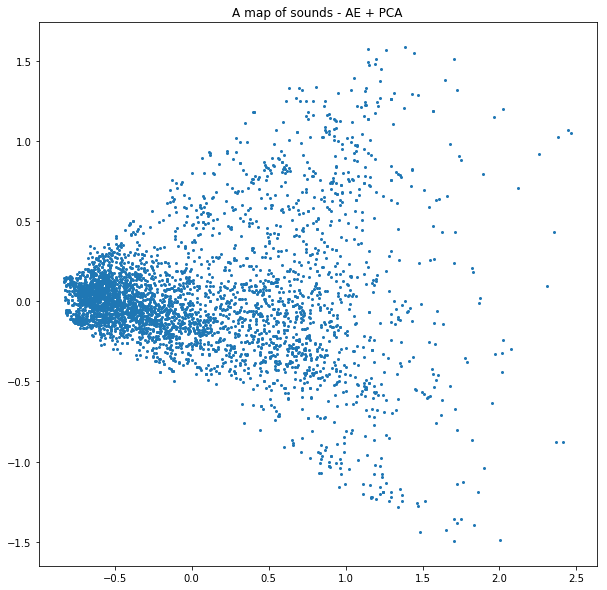

In [170]:
interactiveplot(dimreducedAEPCA, 'A map of sounds - AE + PCA')

PCA again was fast but did not help with the visualization

In [146]:
tsnesolver = TSNE(n_components = 2)
dimreducedAETSNE = tsnesolver.fit_transform(latentspace1)

FigureCanvasNbAgg()

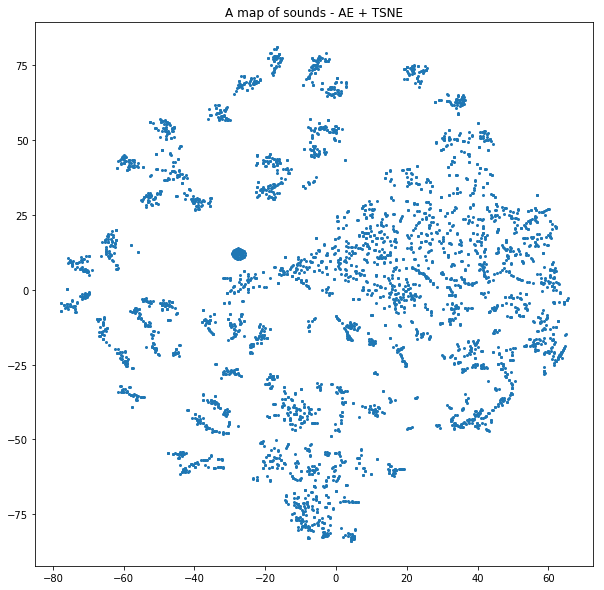

In [171]:
interactiveplot(dimreducedAETSNE, 'A map of sounds - AE + TSNE')

This took much more time but results are really nice. There are many clusters associated with pitch, timbre and envelope.

In [147]:
umapsolver = umap.UMAP()
dimreducedUMAP = umapsolver.fit_transform(latentspace1)

FigureCanvasNbAgg()

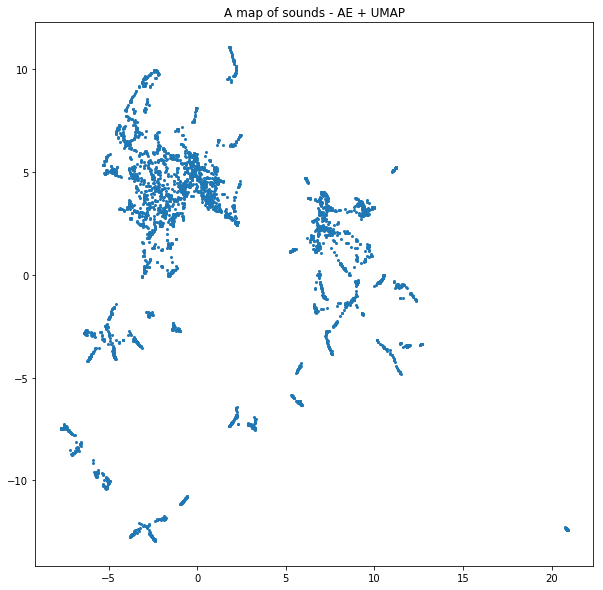

In [172]:
interactiveplot(dimreducedUMAP, 'A map of sounds - AE + UMAP')

Everything seems cluttered. Let's play a bit with UMap parameters. More neighbors tend to preserve more the global structure than the local structure of data. 

In [160]:
umapsolver2 = umap.UMAP(n_neighbors = 50,min_dist = 0.5)
dimreducedUMAP2 = umapsolver2.fit_transform(latentspace1)

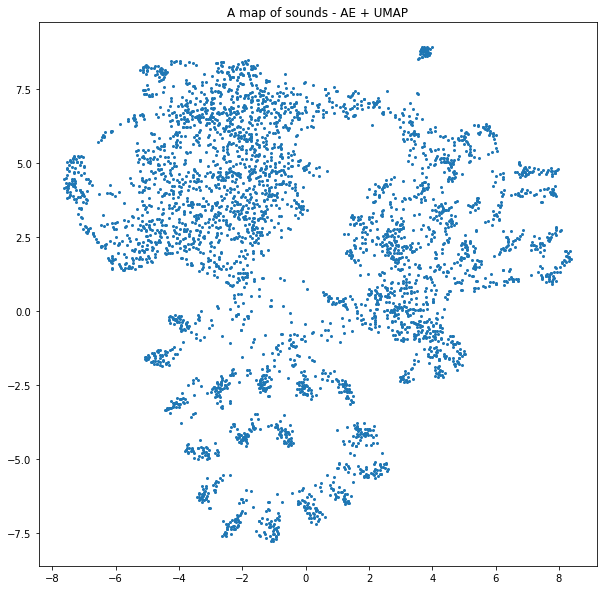

In [173]:
interactiveplot(dimreducedUMAP2, 'A map of sounds - AE + UMAP')

And let's play a bit with tSNE also. Changing perplexity can lead to very different visualizations.

In [149]:
tsnesolver = TSNE(n_components = 2, perplexity = 50, learning_rate = 500, n_iter = 1000)
dimreducedaetsne2 = tsnesolver.fit_transform(latentspace1)

FigureCanvasNbAgg()

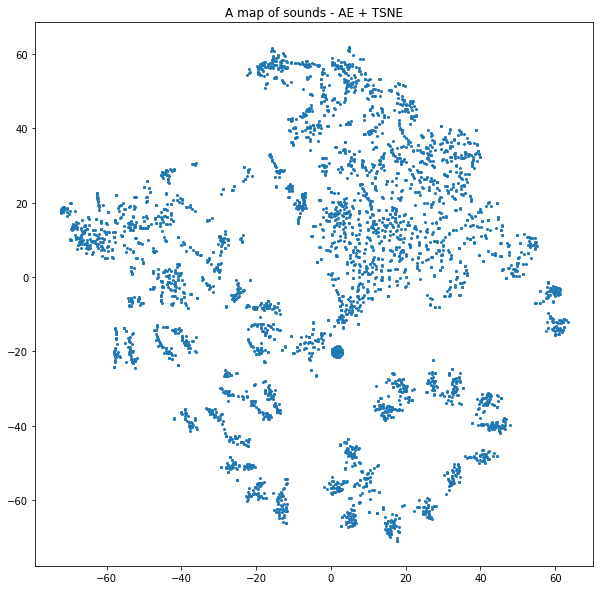

In [174]:
interactiveplot(dimreducedaetsne2, 'A map of sounds - AE + TSNE')

And I think the winner was Autoencoder + tSNE, but that is subjective so the important thing is

What we learnt:

- Preparing audio data and extracting features.
- Using sklearn for dimensionality reduction and umap.
- UMap is a great tool for visualization as it can deal with very high dimensional data.
- Autoencoders alone maybe are not so good for data visualization, but can deal with very high dimensional data and extract features automatically. We learnt to build Convolutional AE and Variational AE.
- tSNE gives good visualizations but can't deal with very high dimensional data.
- A good approach is extracting features with an autoencoder and then applying tSNE.

What to improve:

- Try with other features than MFCC. There are a loooot...
- Deal with raw data and exploit deep learning models (Wavenet Autoencoders? mmm give me many GPUs, Convolutional Autoencoders applied to a time-frequency representation like STFT, CQT, Wavelets..., there are a lot of options but they will give your machine a lot of hard work.)
- Explore other audio datasets, maybe the whole NSynth but with just one pitch so the clusters are not pitch-related and instead are timbre/envelope related. Animal sounds? Drums sounds? Songs? Speakers? Do you have a really large foley sounds library and can't find the right sound? or maybe you are a sound designer with a lot of samples difficult to organise... There are a lot of options to keep playing with audio exploration/visualization, just choose one and see what happens.

##### Any suggestions, feedback, corrections, send me an email to leonardodpepino@gmail.com